Compute EEG residuals from learned encoders, dropping out relevant word-level features (surprisal and frequency).

For word stimuli with matched cohorts (or at least matched likelihoods), find instances which are recognized early vs. late due to context.
Bin and compare residual time series between bins.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [29]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr
from berp.viz import make_word_onset_epochs, make_word_recognition_epochs, epoch_ts
from berp.viz.trf import trf_to_dataframe, plot_trf_coefficients

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
SAVE_FIGURES = True
figure_path = Path(".")

In [7]:
p = ArgumentParser()
p.add_argument("model_base_dir", type=Path, help="Load pipeline and dataset from this base dir")
p.add_argument("subjects", type=str, nargs="+")
p.add_argument("stories", type=str, nargs="+")
p.add_argument("run_names", type=str, nargs="+")

_StoreAction(option_strings=[], dest='run_names', nargs='+', const=None, default=None, type=<class 'str'>, choices=None, required=True, help=None, metavar=None)

In [8]:
if IS_INTERACTIVE:
    args = Namespace(
        # model_base_dir=Path("../../work/2b/cda8e6c76a9235517148309c3afb33/"),
        model_base_dir=Path("../../work/b6/f943409afa218eade300702170b1d1/"),
        subjects=["average"],
        stories=["DKZ_1", "DKZ_2"],
        run_names=["berp-fixed-20221031"],)
else:
    args = p.parse_args()

In [33]:
epoch_kwargs = dict(
    tmin=-12/128, tmax=96/128,
    baseline=True,
    baseline_tmin=-12/128, baseline_tmax=0,
)

## Load results

In [10]:
# Load pipelines.
if len(args.run_names) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

pipes = []
for run in args.run_names:
    # HACK magic string
    pipeline_path = args.model_base_dir / run / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        print(f"Missing pipeline at {pipeline_path}")

    with pipeline_path.open("rb") as f:
        pipes.append(pickle.load(f))
        
    # TODO shape checks etc.

# TODO support more than one pipeline
pipe = pipes[0]

In [11]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = {}
stimulus_paths = {story: args.model_base_dir / f"{story}.pkl" for story in args.stories}
combs = list(product(args.stories, args.subjects))
for story, subject in tqdm(combs):
    ds_path = args.model_base_dir / f"{story}.{subject}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject] = load_eeg_dataset(
        [ds_path], "biosemi64", subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=True, normalize_X_variable=True, normalize_Y=True).datasets[0]

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
sample_ds = next(iter(ds.values()))

## Preprocessing

In [13]:
encoders = {subject: pipe.encoders_[subject] for subject in args.subjects}

In [14]:
feature_names = sample_ds.ts_feature_names + sample_ds.variable_feature_names
feature_names

['binned acoustical edges >100Hz_0',
 'binned acoustical edges >100Hz_1',
 'binned acoustical edges >100Hz_2',
 'binned acoustical edges >100Hz_3',
 'binned acoustical edges >100Hz_4',
 'binned acoustical edges >100Hz_5',
 'binned acoustical edges >100Hz_6',
 'binned acoustical edges >100Hz_7',
 'phoneme entropy_0',
 'phoneme onsets_0',
 'phoneme surprisal_0',
 'binned spectrogram >100Hz_0',
 'binned spectrogram >100Hz_1',
 'binned spectrogram >100Hz_2',
 'binned spectrogram >100Hz_3',
 'binned spectrogram >100Hz_4',
 'binned spectrogram >100Hz_5',
 'binned spectrogram >100Hz_6',
 'binned spectrogram >100Hz_7',
 'word onsets_0',
 'recognition_onset',
 'word_frequency',
 'word_surprisal']

In [ ]:
params = pipe.params[0]

p_candidates, recognition_points, recognition_times = {}, {}, {}
for (story, subject), ds_i in tqdm(ds.items()):
    if story in p_candidates:
        # Already computed.
        continue

    p_candidates[story] = rr.predictive_model(
        ds_i.p_candidates, ds_i.candidate_phonemes,
        confusion=params.confusion,
        lambda_=params.lambda_,
        return_gt_only=False)
    recognition_points[story], recognition_times[story] = \
        pipe.get_recognition_times(ds_i, pipe.params[0])

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
# Estimate median phoneme onset time
# Sloppily estimate phoneme onset averages, just within one dataset
ph_ons = sample_ds.phoneme_onsets.clone()
ph_ons[torch.arange(ph_ons.shape[1]).unsqueeze(0) >= sample_ds.word_lengths.unsqueeze(1)] = np.nan
ph_ons.nanmedian(dim=0)[0]

tensor([0.0000, 0.0700, 0.1600, 0.2700, 0.3400, 0.4100, 0.4800, 0.5500, 0.5900,
        0.6800, 0.7600, 0.8500, 0.8900, 0.9300])

In [141]:
def plot_phoneme_onsets(ax=None):
    ax = ax if ax is not None else plt
    
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    for phoneme_onset_i in ph_ons.nanmedian(axis=0)[0].numpy():
        if phoneme_onset_i > epoch_kwargs["tmax"] or phoneme_onset_i == 0:
            continue
        ax.axvline(phoneme_onset_i, color="salmon", linestyle="--", alpha=0.25)

In [192]:
def plot_variable_trf_window(ax=None):
    ax = ax if ax is not None else plt

    # Show where the effect is actually located according to the pipeline.
    window_line_kwargs = dict(color="orange", linestyle="--", alpha=0.5)
    if pipe.variable_trf_zero_left > 0:
        variable_left_edge = pipe.variable_trf_zero_left / sample_ds.sample_rate
        ax.axvline(variable_left_edge, **window_line_kwargs)
    if pipe.variable_trf_zero_right > 0:
        variable_right_edge = pipe.encoder.tmax - pipe.variable_trf_zero_right / sample_ds.sample_rate
        ax.axvline(variable_right_edge, **window_line_kwargs)

## Compute residual time series

In [22]:
def ablate_encoder(encoder):
    """
    Return a copied encoder with ablated variable-onset coefficients.
    """
    ret = deepcopy(encoder)
    # Zero out variable-onset features.
    variable_onset_feature_start = sample_ds.n_ts_features
    ret.coef_[variable_onset_feature_start:, :, :] = 0.
    return ret

ablated_encoders = {subject: ablate_encoder(encoder) for subject, encoder in encoders.items()}

In [23]:
Y, Y_resid, Y_resid_ablated = {}, {}, {}
for (story, subject), ds_i in tqdm(ds.items()):
    pipe.prime(ds_i)
    
    encoder = encoders[subject]
    ablated_encoder = ablated_encoders[subject]
    
    design_matrix, _ = pipe.pre_transform(ds_i)
    Y_pred = encoder.predict(design_matrix)
    Y_pred_ablated = ablated_encoder.predict(design_matrix)
    
    Y[story, subject] = ds_i.Y
    Y_resid[story, subject] = ds_i.Y - Y_pred
    Y_resid_ablated[story, subject] = ds_i.Y - Y_pred_ablated
    
    mse = (Y_resid[story, subject] ** 2).sum(axis=1).mean()
    mse_ablated = (Y_resid_ablated[story, subject] ** 2).sum(axis=1).mean()
    print(story, subject, mse, mse_ablated, mse - mse_ablated)

  0%|          | 0/2 [00:00<?, ?it/s]

DKZ_1 average tensor(5.9093) tensor(5.9113) tensor(-0.0019)
DKZ_2 average tensor(5.8152) tensor(5.8157) tensor(-0.0005)


In [ ]:
# # Comparison case: what happens when we ablate word onset feature?
# feature_names = ds.ts_feature_names + ds.variable_feature_names
# ablated_encoder2 = deepcopy(encoder)
# ablated_encoder2.coef_[feature_names.index("word onsets_0"), :, :] = 0.

# Y_pred_ablated2 = ablated_encoder2.predict(design_matrix)
# Y_resid_ablated2 = ds.Y - Y_pred_ablated2
# mse_ablated2 = (Y_resid_ablated2 ** 2).sum(axis=1).mean()
# mse_ablated2, mse - mse_ablated2

## Visualize recognition point

In [41]:
# Get recognition points by time and combine into single figure.
recognition_points_pooled = []
recognition_times_pooled = []
for story, recognition_points_i in recognition_points.items():
    # Find a dataset for this story so we can look up word/phoneme onsets.
    ds_i = next(iter(ds_j for (story_j, subject_j), ds_j in ds.items()
                     if story == story_j))
    
    # Compute recognition times relative to word onset
    recognition_times_i = recognition_times[story] - ds_i.word_onsets
    recognition_points_pooled.extend(recognition_points_i.numpy())
    recognition_times_pooled.extend(recognition_times_i.numpy())

In [42]:
rec_df = pd.DataFrame({"Recognition point": np.array(recognition_points_pooled),
                       "Recognition time": recognition_times_pooled})

In [43]:
rec_df["Recognition point"].value_counts()

2     1523
1     1003
3      904
4      417
0      191
5      181
6       60
7       21
8        5
9        2
10       1
Name: Recognition point, dtype: int64

In [231]:
# Prepare hue order for later plots.
rec_hue_order = list(map(str, sorted(rec_df["Recognition point"].unique())))
rec_hue_order

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

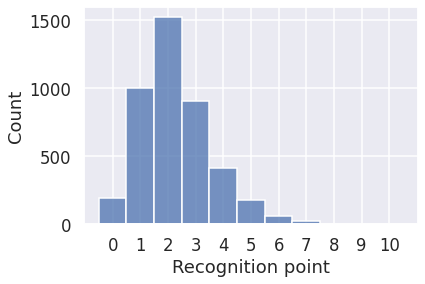

In [46]:
sns.set("talk")
# plt.subplots(figsize=(12, 4))
sns.histplot(data=rec_df, x="Recognition point", bins=11, discrete=True)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
None

<AxesSubplot:xlabel='Recognition time', ylabel='Density'>

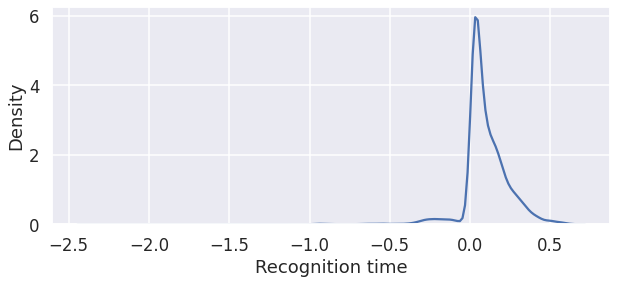

In [47]:
plt.subplots(figsize=(10, 4))
# plt.xlim((0, epoch_tmax))
# plt.ylim((-0.1, 6.5))
sns.kdeplot(data=rec_df, x="Recognition time")

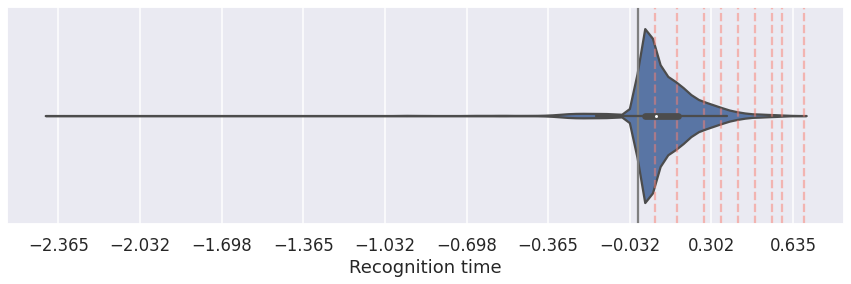

In [49]:
plt.subplots(figsize=(15, 4))

plt.axvline(0, color="gray")
for phoneme_onset_i in ph_ons.nanmedian(axis=0)[0].numpy():
    if phoneme_onset_i > epoch_tmax or phoneme_onset_i == 0:
        continue
    plt.axvline(phoneme_onset_i, color="salmon", linestyle="--", alpha=0.5)

sns.violinplot(data=rec_df, x="Recognition time")
plt.xticks(np.linspace(rec_df["Recognition time"].min(), rec_df["Recognition time"].max(), num=10))
None

## Visualize epoched data

In [216]:
def prepare_all_epochs(ts=None, baseline=True):
    """
    Prepare epochs dataframe with relevant metadata, possibly swapping
    in alternate time series data with `ts`.
    """
    if ts is None:
        ts = {(story, subject): None for story, subject in ds.keys()}

    kwargs = epoch_kwargs | {"baseline": baseline}
    epoch_dfs = {
        (story, subject): make_word_onset_epochs(
            ds_i,
            ts=ts[story, subject],
            **kwargs)
        for (story, subject), ds_i in tqdm(ds.items())
    }
    epoch_df = pd.concat(epoch_dfs, names=["story", "subject", "epoch", "sample", "sensor_idx"]) \
        .reset_index()
    epoch_df["sensor"] = epoch_df.sensor_idx.map(dict(enumerate(target_sensors)))
    
    # Join in recognition point/time information
    to_merge = {story: pd.DataFrame(torch.stack([recognition_points[story], recognition_times[story]]).T.numpy(),
                                    columns=["recognition_point", "recognition_time"])
                for story in recognition_points}
    to_merge = pd.concat(to_merge, names=["story", "word_idx"])
    
    epoch_df = pd.merge(epoch_df.reset_index(), to_merge, on=["story", "word_idx"])
    epoch_df["recognition_point_str"] = epoch_df.recognition_point.astype(int).astype(str)
    
    return epoch_df

In [217]:
epoch_df = prepare_all_epochs()
epoch_df

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

index  story  subject  epoch  sample  sensor_idx     value  \
0              0  DKZ_1  average      0       0           0  0.548574   
1              1  DKZ_1  average      0       0           1  0.611650   
2              2  DKZ_1  average      0       0           2  0.797128   
3              3  DKZ_1  average      0       0           3  0.239589   
4              4  DKZ_1  average      0       0           4  0.709568   
...          ...    ...      ...    ...     ...         ...       ...   
2791579  2791579  DKZ_2  average   2117     107           1  3.497837   
2791580  2791580  DKZ_2  average   2117     107           2  1.755144   
2791581  2791581  DKZ_2  average   2117     107           3  2.182889   
2791582  2791582  DKZ_2  average   2117     107           4  2.140214   
2791583  2791583  DKZ_2  average   2117     107           5  2.388415   

         epoch_time  word_idx sensor  recognition_point  recognition_time  \
0         -0.093750         0     C1                5.0          1.425000   
1         -0.093750         0     Cz                5.0          1.425000   
2         -0.093750         0     C2                5.0          1.425000   
3         -0.093750         0    CP1                5.0          1.425000   
4         -0.093750         0    CPz                5.0          1.425000   
...             ...       ...    ...                ...               ...   
2791579    0.742188      2117     Cz                3.0        907.179932   
2791580    0.742188      2117     C2                3.0        907.179932   
2791581    0.742188      2117    CP1                3.0        907.179932   
2791582    0.742188      2117    CPz                3.0        907.179932   
2791583    0.742188      2117    CP2                3.0        907.179932   

        recognition_point_str  
0                           5  
1                           5  
2                           5  
3                           5  
4                           5  
...                       ...  
2791579                     3  
2791580                     3  
2791581                     3  
2791582                     3  
2791583                     3  

[2791584 rows x 13 columns]

In [218]:
epoch_df_nobaseline = prepare_all_epochs(baseline=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [219]:
# Epoch predicted data.
epochs_pred_df = prepare_all_epochs({
    (story, subject): ds_i.Y - Y_resid[story, subject]
    for (story, subject), ds_i in tqdm(ds.items())
}, baseline=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [220]:
# Epoch predicted data from ablated model.
epochs_pred_ablated_df = prepare_all_epochs({
    (story, subject): ds_i.Y - Y_resid_ablated[story, subject]
    for (story, subject), ds_i in tqdm(ds.items())
}, baseline=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [232]:
# Epoch residual data
epochs_resid_df = prepare_all_epochs(Y_resid, baseline=False)
epochs_resid_ablated_df = prepare_all_epochs(Y_resid_ablated, baseline=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

### Average word response

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

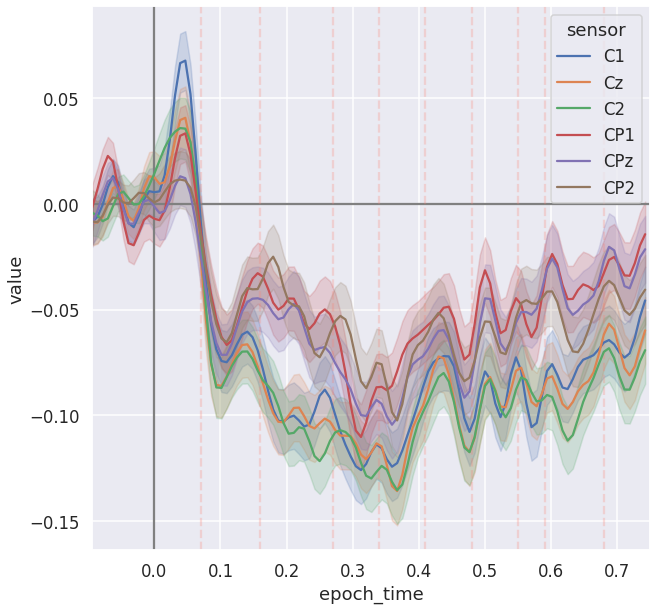

In [221]:
plt.subplots(figsize=(10, 10))
plot_phoneme_onsets()
plt.xlim((epoch_tmin, epoch_tmax))

sns.lineplot(data=epoch_df.reset_index(),
             x="epoch_time", y="value", hue="sensor", errorbar="se")

### Average word response vs. predicted

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

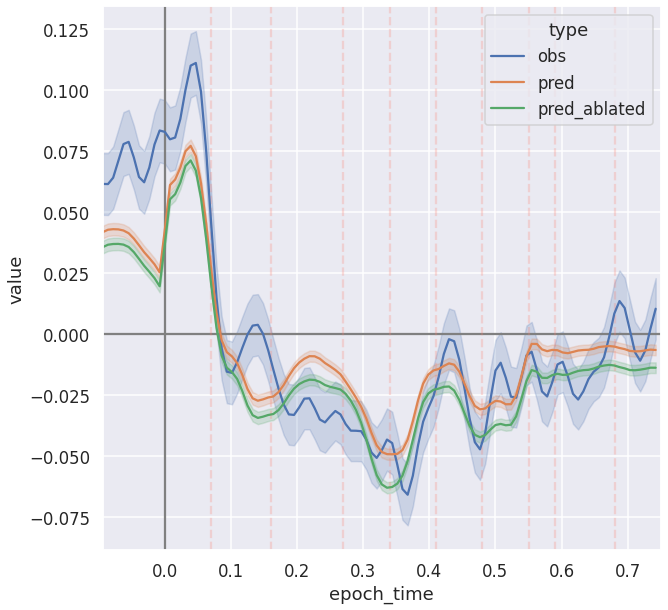

In [222]:
f, ax = plt.subplots(figsize=(10, 10))
plot_phoneme_onsets(ax)
plt.xlim((epoch_tmin, epoch_tmax))

to_plot = pd.concat(
    [x.reset_index() for x in [epoch_df_nobaseline, epochs_pred_df, epochs_pred_ablated_df]],
    names=["type"], keys=["obs", "pred", "pred_ablated"])
# DEV
to_plot = to_plot[to_plot.sensor == "Cz"]
sns.lineplot(data=to_plot.reset_index(),
             x="epoch_time", y="value", hue="type", errorbar="se", ax=ax)

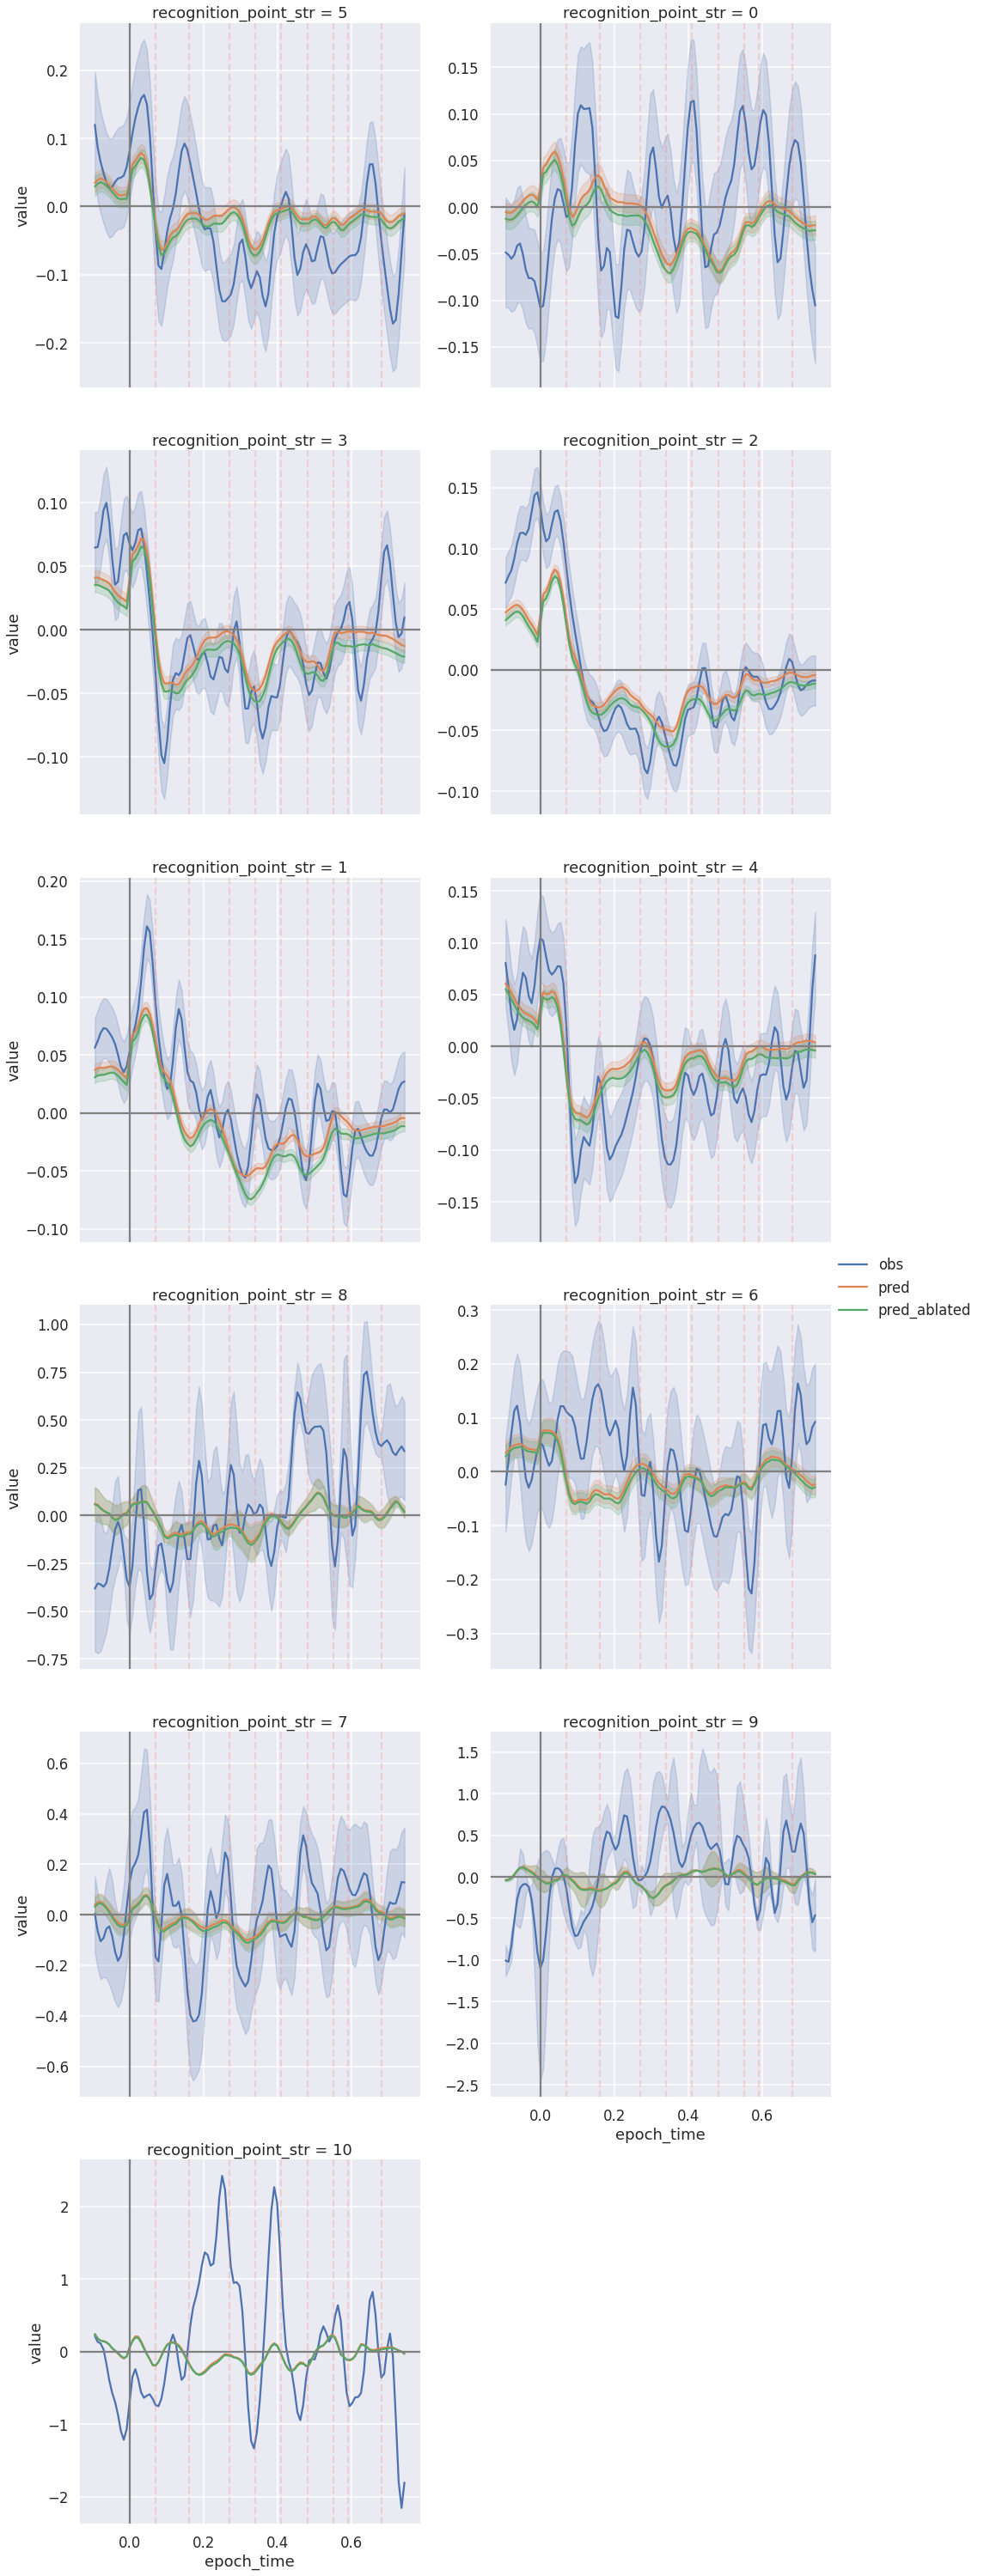

In [227]:
g = sns.FacetGrid(data=to_plot.reset_index(),
                  sharex=True, sharey=False,
                  col="recognition_point_str", col_wrap=4, height=7)
g.map(sns.lineplot, "epoch_time", "value", "type", errorbar="se")
g.add_legend()

# TODO something is wrong -- these predicted values shouldn't differ before the recognition point
# so for late recognition points, there should be no difference early in the word
for ax in g.axes.ravel():
    plot_phoneme_onsets(ax)

### Average residual response

(-0.09375, 0.75)

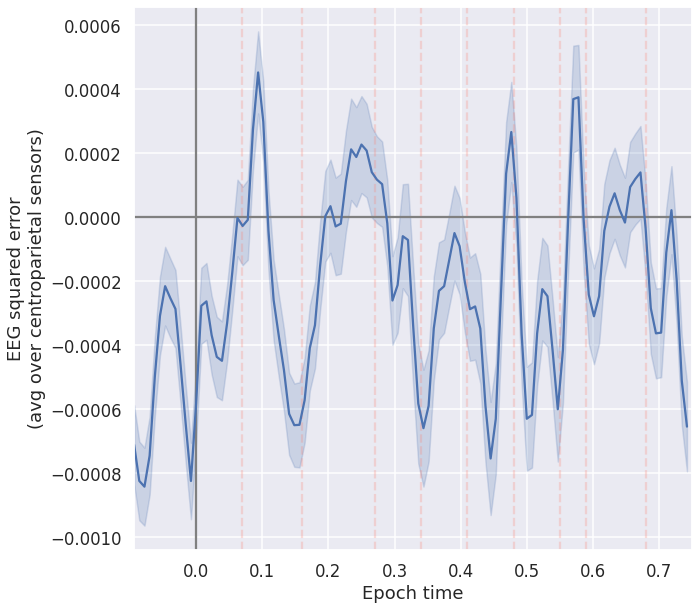

In [257]:
sns.set("talk")
f, ax = plt.subplots(figsize=(10, 10))
plot_phoneme_onsets(ax)

key = [
    # uniquely identifies an epoch value
    "subject", "story", "word_idx", "sample", "sensor",
    # also include metadata
    "epoch_time", "recognition_point_str"
]
to_plot = epochs_resid_df.set_index(key).value ** 2 - epochs_resid_ablated_df.set_index(key).value ** 2
sns.lineplot(data=to_plot.reset_index(),
             x="epoch_time", y="value", errorbar="se", ax=ax)

plt.xlabel("Epoch time")
plt.ylabel("EEG squared error\n(avg over centroparietal sensors)")
plt.xlim((epoch_kwargs["tmin"], epoch_kwargs["tmax"]))

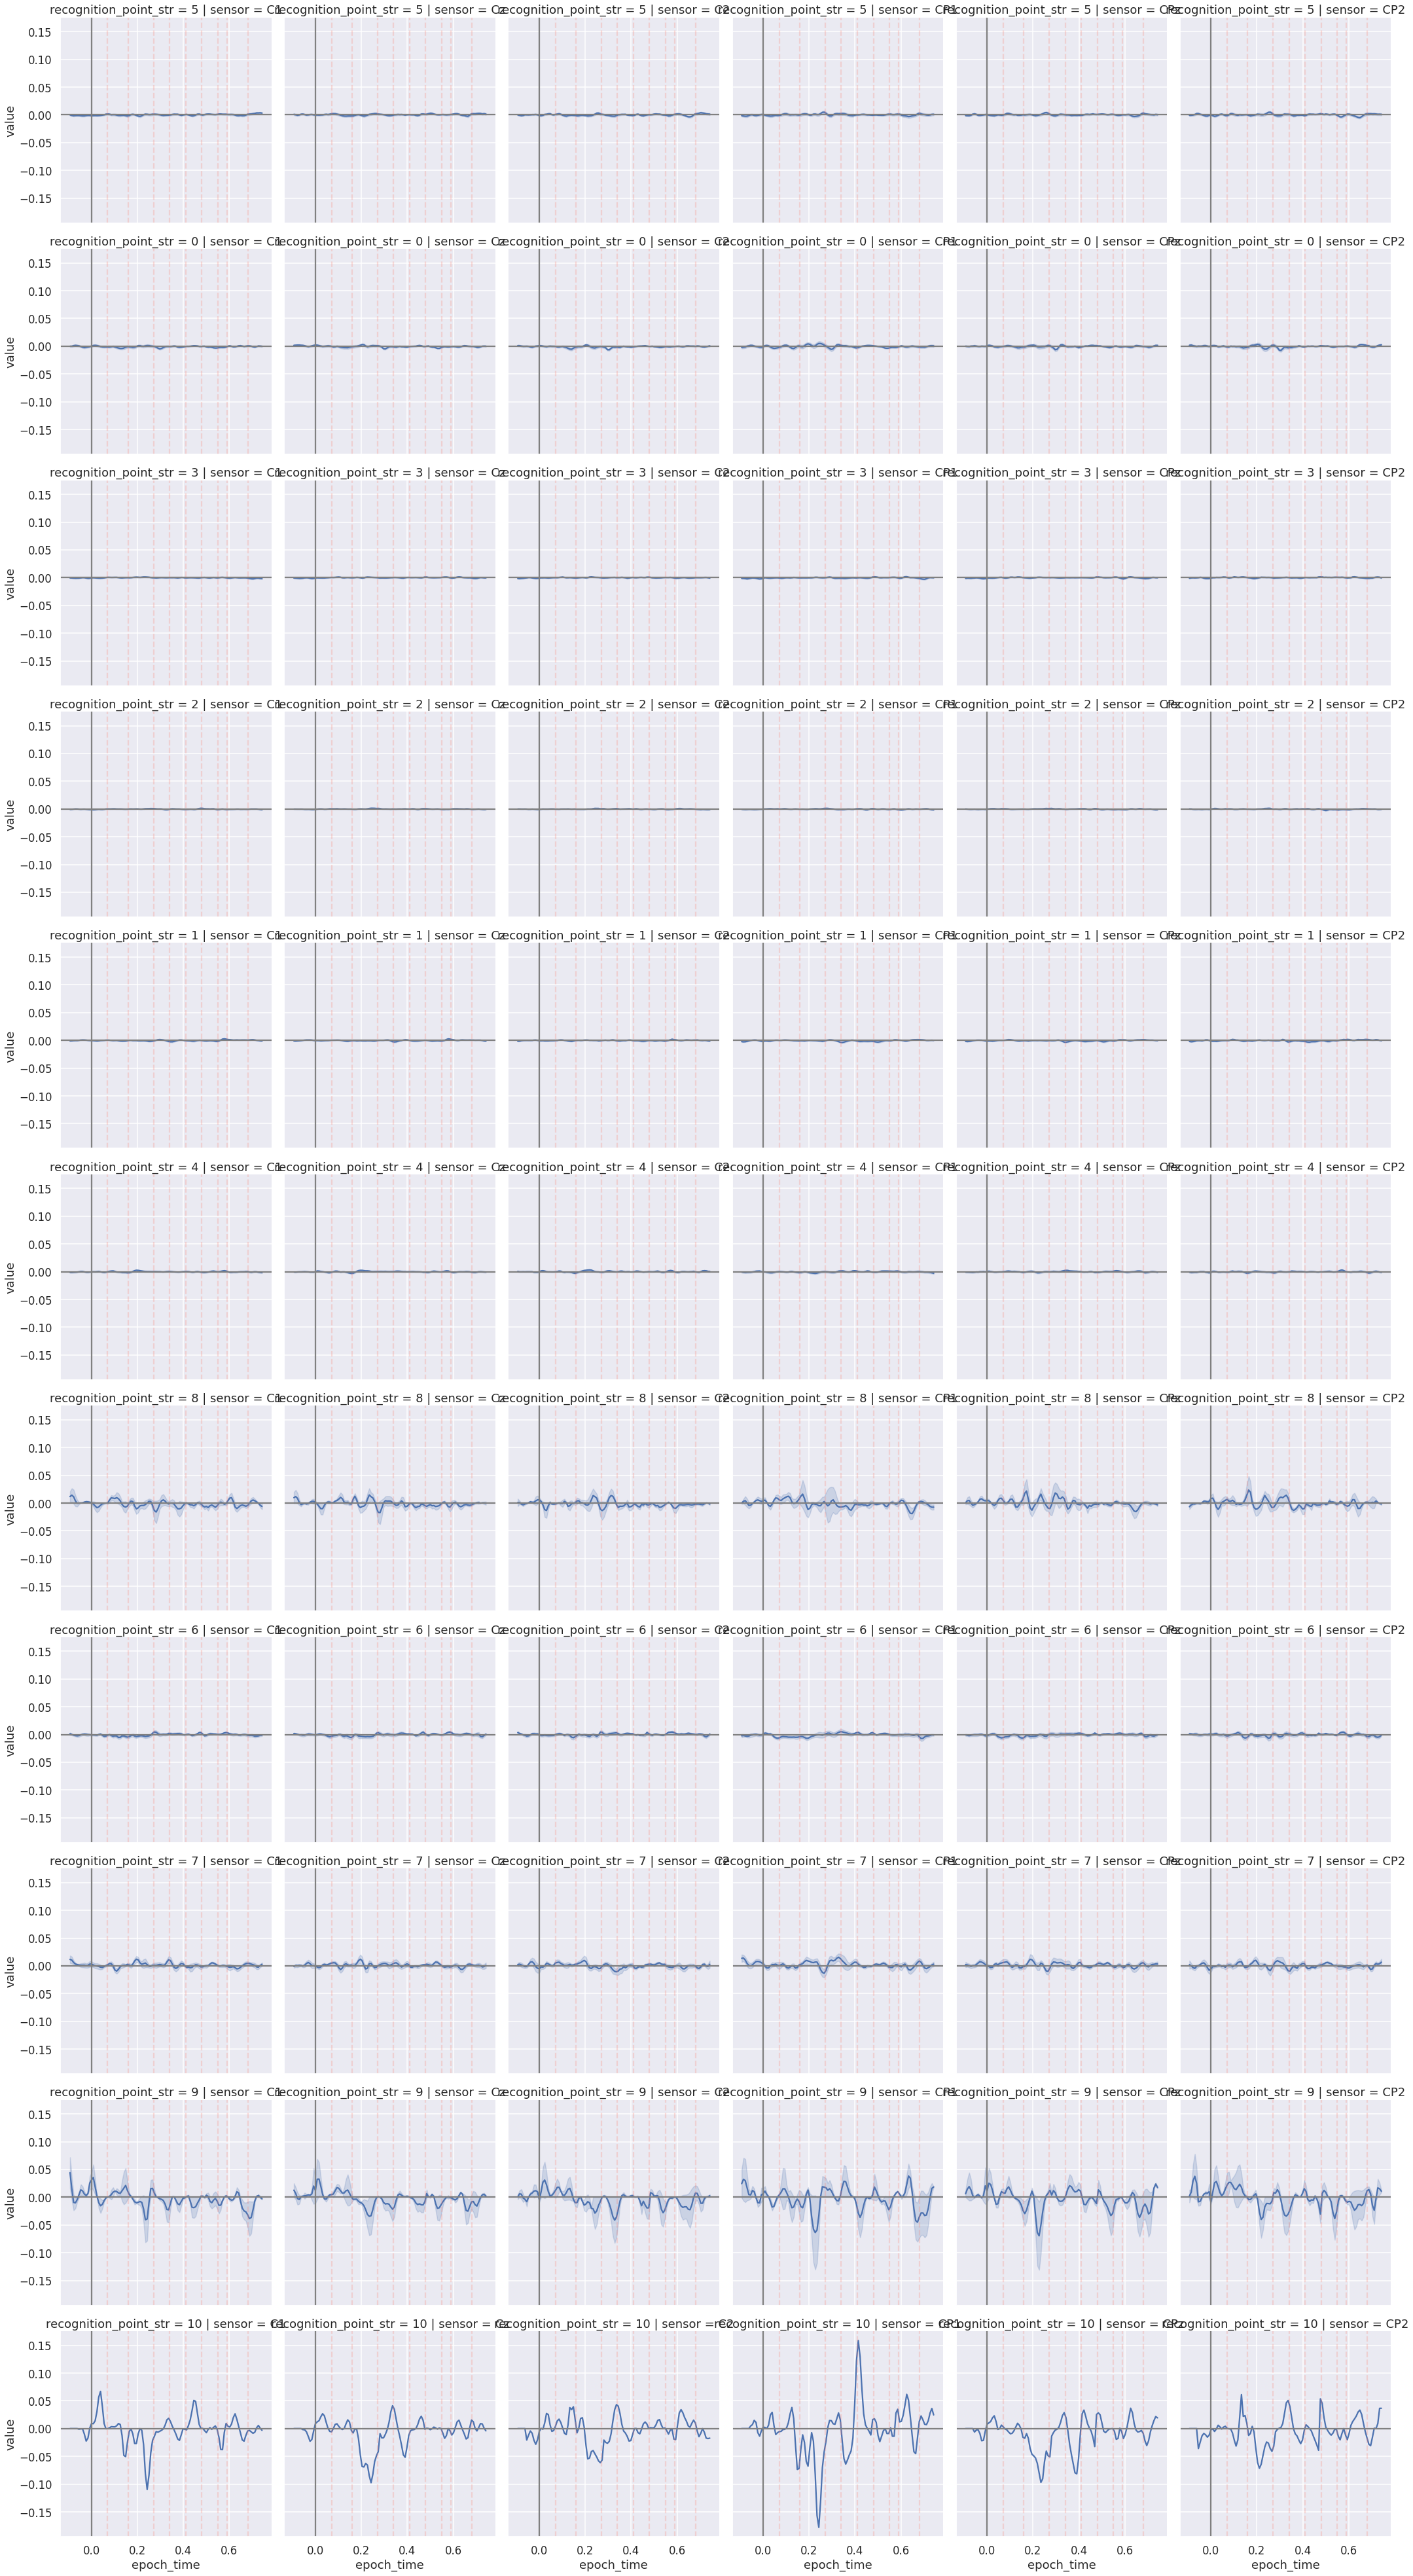

In [259]:
g = sns.FacetGrid(data=to_plot.reset_index(),
                  sharex=True, sharey=True,
                  row="recognition_point_str", col="sensor", height=5)
g.map(sns.lineplot, "epoch_time", "value", errorbar="se")
g.add_legend()

# TODO something is wrong -- these predicted values shouldn't differ before the recognition point
# so for late recognition points, there should be no difference early in the word
for ax in g.axes.ravel():
    plot_phoneme_onsets(ax)

### Average residual response, grouped by recognition point

<AxesSubplot:xlabel='Recognition time', ylabel='Count'>

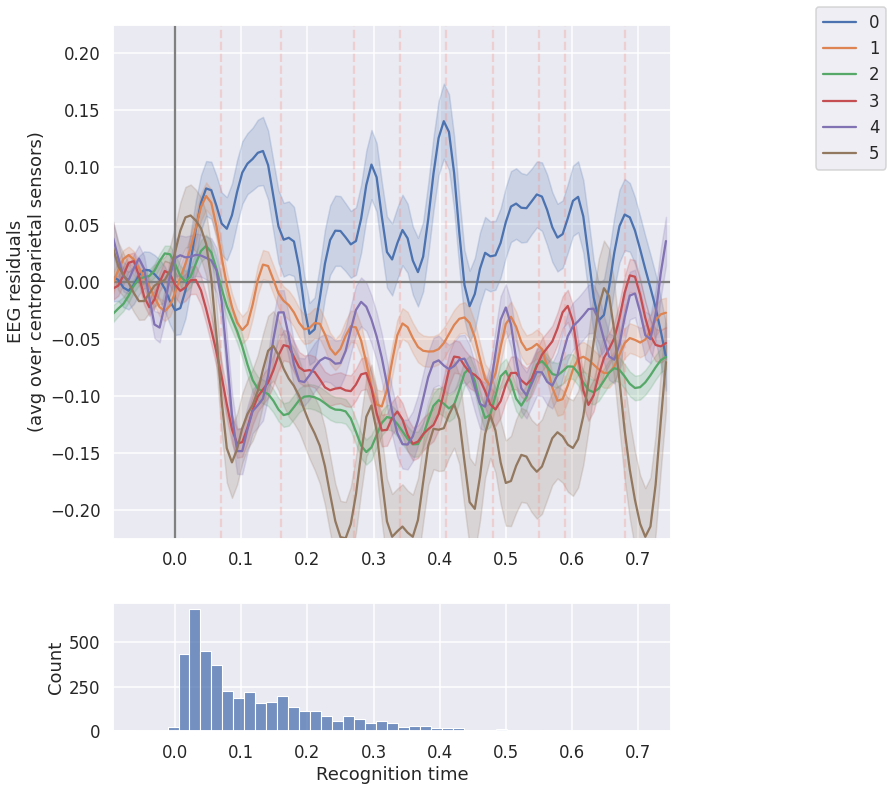

In [142]:
sns.set("talk")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 13),
                             gridspec_kw={"height_ratios": [4, 1]})

plot_phoneme_onsets(ax1)

sns.lineplot(data=epoch_df.reset_index(),
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order,
             errorbar="se",
             ax=ax1)
ax1.set_xlabel("Epoch time")
ax1.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
ax1.legend(bbox_to_anchor=(1.4, 1.05))
plt.xlim((epoch_kwargs["tmin"], epoch_kwargs["tmax"]))
ax1.set_ylim((-.225, .225))
ax1.xaxis.set_tick_params(which="both", labelbottom=True)

sns.histplot(data=rec_df, x="Recognition time", ax=ax2)

In [67]:
if SAVE_FIGURES:
    # Render incremental stacking of these lines
    fig_name_template = "residuals_grouped_max{max}.png"
    sns.set("talk")
    
    for max_phon in trange(6):
        to_plot = epoch_df[epoch_df.recognition_point <= max_phon] \
            .reset_index()
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axhline(0, color="gray")
        ax.axvline(0, color="gray")
        
        sns.lineplot(data=to_plot,
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order[:max_phon + 1],
             errorbar="se", ax=ax)
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
        # ax.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.set_xlim((epoch_tmin, epoch_tmax))
        ax.set_ylim((-.225, .225))
        
        fig.savefig(figure_path / fig_name_template.format(max=max_phon))
        plt.close(fig)

  0%|          | 0/6 [00:00<?, ?it/s]

## Epoch by recognition point

### Show epoched data, indexed by recognition point

In [61]:
rec_epoch_reindex_df = {}
for story, recognition_points_ds in tqdm(recognition_points.items()):
    recognition_times_ds = recognition_times[story]

    word_ids = torch.arange(recognition_points_ds.shape[0])
    
    for subject, encoder in encoders.items():
        ds_i = ds[story, subject]
        eeg_data = Y_resid_ablated[story, subject]

        rec_epoch_reindex_df[story, subject] = make_word_recognition_epochs(
            ds_i, recognition_points_ds[word_ids], recognition_times_ds[word_ids],
            word_ids, ts=eeg_data,
            **epoch_kwargs)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [62]:
rec_epoch_reindex_df = pd.concat(rec_epoch_reindex_df)
rec_epoch_reindex_df.index.set_names(["story", "subject"], level=[0, 1], inplace=True)
# Force categorical color scheme
rec_epoch_reindex_df["recognition_point_str"] = rec_epoch_reindex_df.recognition_point.astype(str)
rec_epoch_reindex_df

value  epoch_time  word_idx  \
story subject epoch sample sensor_idx                                   
DKZ_1 average 0     0      0           2.073337   -0.093750         0   
                           1           2.286435   -0.093750         0   
                           2           2.302309   -0.093750         0   
                           3           1.621463   -0.093750         0   
                           4           1.971295   -0.093750         0   
...                                         ...         ...       ...   
DKZ_2 average 2117  107    1           2.137416    0.742188      2117   
                           2           1.215625    0.742188      2117   
                           3           0.556790    0.742188      2117   
                           4           1.163876    0.742188      2117   
                           5           0.792527    0.742188      2117   

                                       recognition_point  recognition_time  \
story subject epoch sample sensor_idx                                        
DKZ_1 average 0     0      0                           5          1.425000   
                           1                           5          1.425000   
                           2                           5          1.425000   
                           3                           5          1.425000   
                           4                           5          1.425000   
...                                                  ...               ...   
DKZ_2 average 2117  107    1                           3        907.179932   
                           2                           3        907.179932   
                           3                           3        907.179932   
                           4                           3        907.179932   
                           5                           3        907.179932   

                                      recognition_point_str  
story subject epoch sample sensor_idx                        
DKZ_1 average 0     0      0                              5  
                           1                              5  
                           2                              5  
                           3                              5  
                           4                              5  
...                                                     ...  
DKZ_2 average 2117  107    1                              3  
                           2                              3  
                           3                              3  
                           4                              3  
                           5                              3  

[2791584 rows x 6 columns]

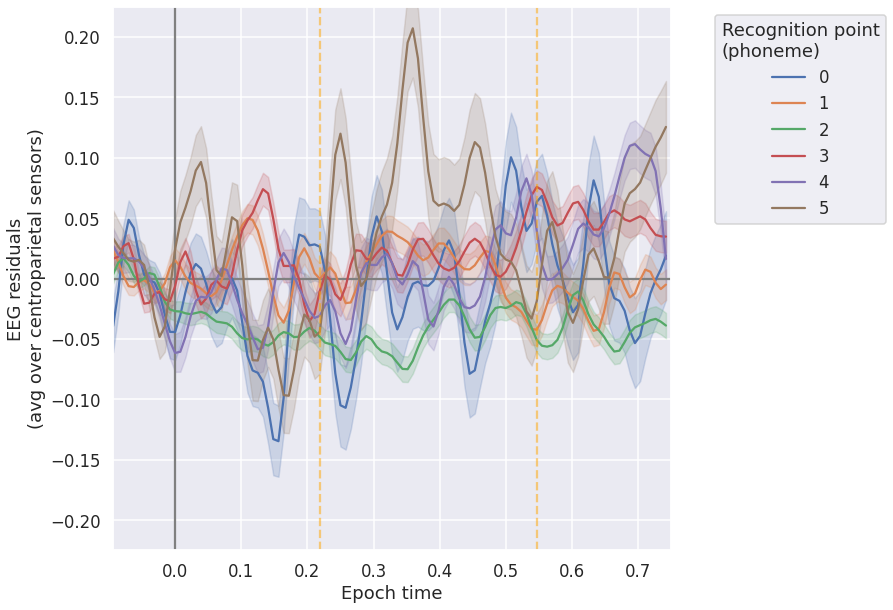

In [124]:
sns.set("talk")

plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")

sns.lineplot(data=rec_epoch_reindex_df.reset_index(),
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order,
             errorbar="se")
plt.xlabel("Epoch time")
plt.ylabel("EEG residuals\n(avg over centroparietal sensors)")
plt.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
plt.xlim((epoch_kwargs["tmin"], epoch_kwargs["tmax"]))
plt.ylim((-.225, .225))

plot_variable_trf_window()

In [66]:
if SAVE_FIGURES:
    # Render incremental stacking of these lines
    fig_name_template = "residuals_grouped_recpoint_max{max}.png"
    sns.set("talk")
    
    for max_phon in trange(6):
        to_plot = rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point <= max_phon] \
            .reset_index()
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.axhline(0, color="gray")
        ax.axvline(0, color="gray")
        
        sns.lineplot(data=to_plot,
             x="epoch_time", y="value",
             hue="recognition_point_str", hue_order=rec_hue_order[:max_phon + 1],
             errorbar="se", ax=ax)
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("EEG residuals\n(avg over centroparietal sensors)")
        # ax.legend(title="Recognition point\n(phoneme)", bbox_to_anchor=(1.4, 1))
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.set_xlim((epoch_tmin, epoch_tmax))
        ax.set_ylim((-.225, .225))
        
        # Show where the effect is actually located according to the pipeline.
        window_line_kwargs = dict(color="orange", linestyle="--", alpha=0.5)
        if pipe.variable_trf_zero_left > 0:
            variable_left_edge = pipe.variable_trf_zero_left / sample_ds.sample_rate
            ax.axvline(variable_left_edge, **window_line_kwargs)
        if pipe.variable_trf_zero_right > 0:
            variable_right_edge = pipe.encoder.tmax - pipe.variable_trf_zero_right / sample_ds.sample_rate
            ax.axvline(variable_right_edge, **window_line_kwargs)
        
        fig.savefig(figure_path / fig_name_template.format(max=max_phon))
        plt.close(fig)

  0%|          | 0/6 [00:00<?, ?it/s]

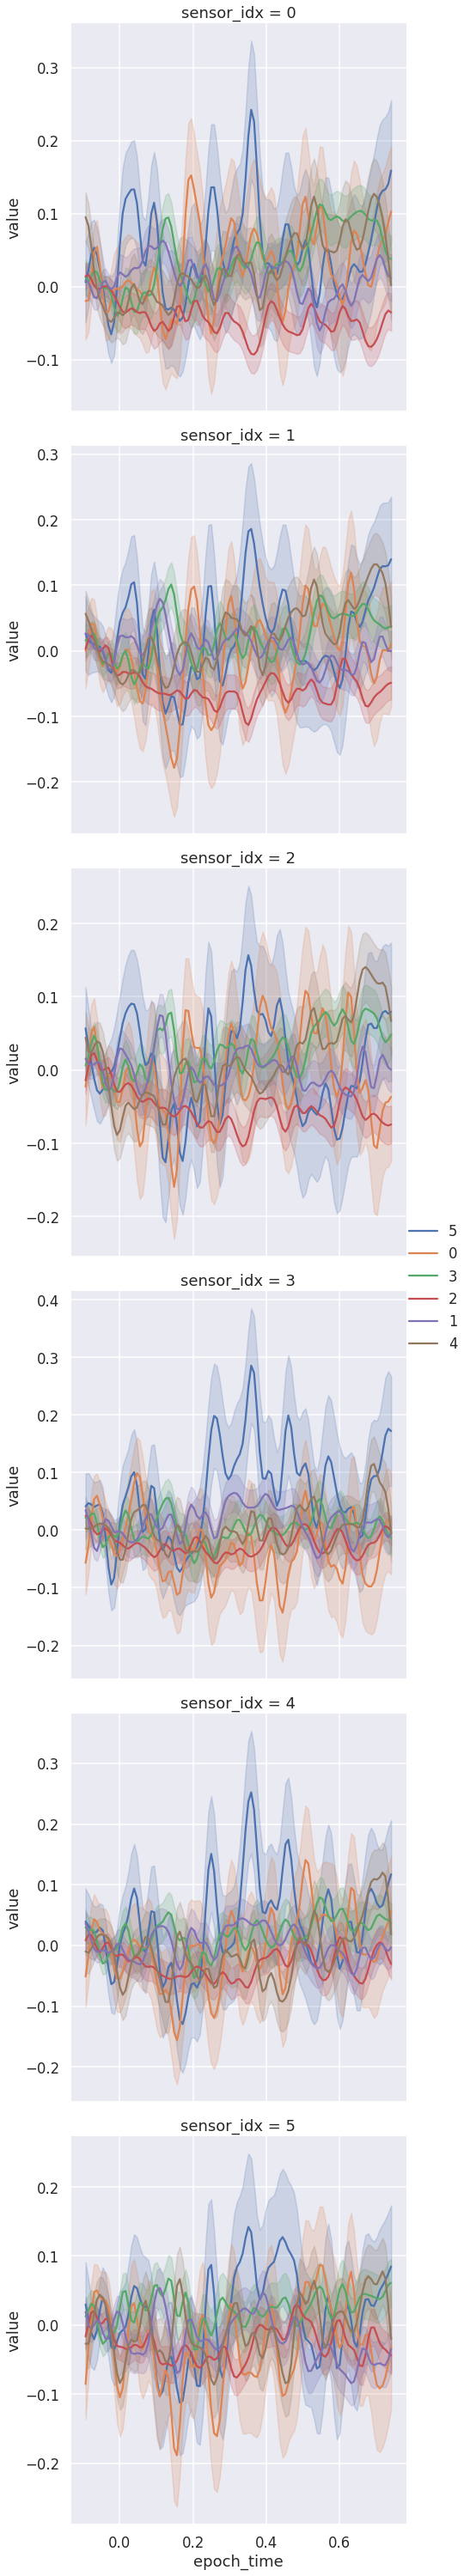

In [65]:
g = sns.FacetGrid(data=rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point_str.isin(rec_hue_order)].reset_index(),
                  row="sensor_idx", sharey=False, height=7, hue_order=rec_hue_order)
g.map(sns.lineplot, "epoch_time", "value", "recognition_point_str", errorbar="se").add_legend()

## Epoch by likelihood

### Prepare prior/posterior dataframes

In [ ]:
prior_df = pd.concat({
    story: pd.DataFrame(p_candidates[story][:, 0, 0].numpy()) \
        .rename_axis(index="epoch", columns="recognition_point")
    for story in p_candidates.keys()
}, names=["story"])
    #.reset_index().melt(id_vars=["story", "epoch"], value_name="pval")
prior_df = prior_df.rename(columns=lambda x: "p_prior" if x == 0 else f"p_phoneme_{x}")

num_quantiles = 4
prior_df["q_prior"] = pd.qcut(prior_df.p_prior, num_quantiles, labels=np.arange(num_quantiles))
prior_df

In [ ]:
# Compute incremental phoneme likelihoods.
confusion = pipe.confusion.pow(1 / pipe.lambda_)
confusion /= confusion.sum(dim=0, keepdim=True)

incremental_word_likelihoods = {}
for story in tqdm(p_candidates):
    ds_i = next(ds_j for (story_j, subject_j), ds_j in ds.items()
                if story == story_j)
    
    ground_truth_phonemes = sample_ds.candidate_phonemes[:, 0, :].unsqueeze(1)
    phoneme_likelihoods = confusion[sample_ds.candidate_phonemes, ground_truth_phonemes].log()
    lik_i = phoneme_likelihoods.cumsum(dim=2)
    lik_i /= lik_i.sum(dim=1, keepdim=True)
    
    incremental_word_likelihoods[story] = pd.DataFrame(lik_i[:, 0, :].numpy()) \
        .rename_axis(index="epoch", columns="likelihood") \
        .rename(columns=lambda x: f"lik_{x+1}")

In [ ]:
incremental_word_likelihoods["DKZ_1"]

In [ ]:
epochs_merged = pd.merge(
    epoch_df, prior_df,
    how="left", on=["story", "epoch"])
epochs_merged

In [ ]:
to_plot = epochs_merged.copy()
to_plot["likelihood"] = pd.qcut(to_plot.p_phoneme_3, 2, labels=np.arange(2))

g = sns.FacetGrid(data=to_plot.reset_index(), sharex=True, col="q_prior", height=5)
g.map(sns.lineplot, "epoch_time", "value", "likelihood", errorbar=None)
# plt.subplots(figsize=(10, 10))
# plt.axvline(0, color="gray")
# plt.axhline(0, color="gray")
# sns.lineplot(data=to_plot.reset_index(), x="epoch_time", y="value", hue="likelihood")